<a href="https://colab.research.google.com/github/Neelakash-gituser/BODMAS-Cloudcraftz-Competition/blob/master/Experiment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Summary of Experiment 
**This experiment involves trade, where we are buying or selling a single stock (+1 or -1) , or doing nothing (0) each trading day .** 

`observation_space = ['close', 'action_taken']`, 
where `action_taken` = [1, 0, -1]

`action_space = [1, 0, -1]`

`reward` = $ action * (close_{t} - close_{t-1}) $

`Model Used` : `A2C` from `stable_baselines3`

**Note**: There is no concept of cash, no accumulation of stocks .

In [1]:
!pip install stable-baselines3

     |████████████████████████████████| 177 kB 4.8 MB/s 
     |████████████████████████████████| 1.5 MB 6.3 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=a411e2fa8d5de6bc600f445a58a1d4eae7d92081bfa4b4a0e252c7ac5d5c4e92
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


#### Import Statements

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import gym 
import random
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from scipy.stats import kurtosis
from pandas._libs import index
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

from stable_baselines3 import A2C

plt.rcParams['axes.facecolor'] = 'lightblue'

#### External Functions (API's)

In [35]:
def dataframe(ticker, start, end, tech_indi=['close']):
    df = pd.read_csv(f'/content/gdrive/MyDrive/NewSignals/{ticker}.csv')
    # df.drop(df.columns[0], axis=1, inplace=True)
    df.drop("close", axis=1, inplace=True)
    df.rename(columns={"price":"close"}, inplace=True)
    df.set_index('date', inplace=True)
    df = df.loc[start:end, tech_indi]
    df.reset_index(drop=True, inplace=True)

    return df, start, end

In [44]:
def summary(envF, env):

    train = pd.DataFrame(envF.return_df)
    test = pd.DataFrame(env.return_df)

    # Time Periods
    train_period = (pd.to_datetime(envF.end) - pd.to_datetime(envF.start))//np.timedelta64(1, 'M')
    test_period = (pd.to_datetime(env.end) - pd.to_datetime(env.start))//np.timedelta64(1, 'M')

    # Daily Returns 
    train['returns'] = (train['reward_t']/abs(train['action_t'])) / train['price_t']
    test['returns'] = (test['reward_t']/abs(test['action_t'])) / test['price_t']

    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True) 

    # Compounded Returns 
    train['ret_cp'] = 0
    test['ret_cp'] = 0

    train.loc[0, 'ret_cp'] = train.loc[0, 'returns']
    train_ret = train['returns'].to_list()
    for t in range(1, len(train['returns'])):
        train.loc[t, 'ret_cp'] = (1 + train.loc[t-1, 'ret_cp']) * (1 + train_ret[t]) - 1

    test.loc[0, 'ret_cp'] = test.loc[0, 'returns']
    test_ret = test['returns'].to_list()
    for t in range(1, len(test['returns'])):
        test.loc[t, 'ret_cp'] = (1 + test.loc[t-1, 'ret_cp']) * (1 + test_ret[t]) - 1


    # Cumulative Rewards
    train['cum_reward'] = train['reward_t'].cumsum()
    test['cum_reward'] = test['reward_t'].cumsum()

    # The total df
    total_df = pd.concat([train, test], axis=0)
    total_df.reset_index(drop=True, inplace=True)

    train_index = len(train['returns'].values)

    # Total Reward
    total_reward_train = train['reward_t'].sum()
    total_reward_test = test['reward_t'].sum()

    # Return Per Period
    train_period_return = (train['ret_cp'].loc[len(train['ret_cp'])-1]/train_period) * 100
    test_period_return = (test['ret_cp'].loc[len(test['ret_cp'])-1]/test_period) * 100

    # Annualized Return 
    train_annual_return = train_period_return * 12
    test_annual_return = test_period_return * 12

    # Volatility 
    train_vol = np.std(train['returns']) * np.sqrt(252)
    test_vol = np.std(test['returns']) * np.sqrt(252)

    # Sharpe Ratio
    train_sharpe = (train['returns'].mean()/np.std(train['returns'])) * np.sqrt(252)
    test_sharpe = (test['returns'].mean()/np.std(test['returns'])) * np.sqrt(252)

    # Kurtosis
    train_kurtosis = (kurtosis(train['returns'], fisher=False))
    test_kurtosis = (kurtosis(test['returns'], fisher=False))

    # data for buy/sell points
    buy, sell, hold = [], [], []
    action_list = np.arange(len(total_df['action_t']))

    for i, j  in enumerate(action_list):
        if total_df.loc[i, 'action_t'] > 0:
            buy.append(j)
        elif total_df.loc[i, 'action_t'] < 0:
            sell.append(j)
        else:
            hold.append(j)


    # Legend Items
    green_triangle = mlines.Line2D([], [], color='green', marker='^', linestyle='None',
                          markersize=10, label='Buy')
    
    red_triangle = mlines.Line2D([], [], color='red', marker='v', linestyle='None',
                          markersize=10, label='Sell')

    


    # buy or sell points
    plt.figure(figsize=(15, 5))
    plt.title("Buy/Sell Points", fontweight="bold")
    plt.plot(total_df['price_t'].rolling(30).mean(), 'b-')
    plt.plot(buy, total_df.loc[buy, 'price_t'], 'g^')
    plt.plot(sell, total_df.loc[sell, 'price_t'], 'rv')
    plt.xlabel("Days", fontsize=13)
    plt.ylabel("Price in $", fontsize=13)
    plt.grid()
    plt.legend(handles=[green_triangle, red_triangle])

    plt.tight_layout()
    

    # cum_reward plot
    plt.figure(figsize=(15, 5))
    plt.title("Train vs Test Period Rewards (30 days Moving)", fontweight="bold")
    plt.plot(total_df['cum_reward'].loc[:train_index].rolling(30).mean(), 'g-')
    plt.plot(total_df['cum_reward'].loc[train_index:].rolling(30).mean(), 'r-')
    plt.xlim(0, 3000)
    plt.xlabel("Days", fontsize=13)
    plt.ylabel("Cumulative Rewards", fontsize=13)
    plt.grid()
    plt.legend(['Train', 'Test'], fontsize=13)

    plt.tight_layout()
    

    # Final DataFrame
    df = pd.DataFrame(data=[ 
                            [envF.start, env.start],
                            [envF.end, env.end],
                            [int(train_period), int(test_period)],
                            [total_reward_train, total_reward_test],
                            [train_period_return, test_period_return],
                            [train_annual_return, test_annual_return],
                            [train_vol, test_vol],
                            [train_sharpe, test_sharpe],
                            [train_kurtosis, test_kurtosis]
                            ] ,
                      
                      columns=['Train', 'Test'], 
                      index=['Start Date', 'End Date', 'Time Period (in Months)', 'Total Reward', 'Return/Month %', 'Annual Return %', 
                             'Annual Volatility', 'Sharpe Ratio', 'Kurtosis'])

    return df

#### Environment

In [36]:
class Cloudcraftz(gym.Env):
    def __init__(self, ticker, start, end):
        self.df, self.start, self.end = dataframe(ticker, start, end)
        self._current = None
        self._end_tick = len(self.df['close']) - 1
        self.actions = []
        self.rewards = []
        self.return_df = {}

        # observation space and action space
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.df.shape[1]+1,))
        self.action_space = gym.spaces.Discrete(3)

    def step(self, action):
        # Mapping 0-> -1, 1-> 0, 2-> 1
        action = action - 1
        # print(action) 

        obs = self.obs

        # Moving towards new day
        self._current += 1

        # New day
        new_obs = np.array(list(self.df.loc[self._current].to_numpy()) + [action])

        # reward
        reward = action * (new_obs[0] - obs[0])

        self.actions.append(action)
        self.rewards.append(reward)
        self.price_today.append(obs[0])
        self.price_tom.append(new_obs[0])

        # check
        if self._current == self._end_tick:
            print("Done")
            done = True
            self.return_df = None
            self.return_df = {'price_t': self.price_today, 'reward_t': self.rewards, 'action_t': self.actions, 'price_t+1': self.price_tom}
        else:
            done = False
        
        self.obs = new_obs

        return (self.obs).astype(np.float32), reward, done, {}
    
    def reset(self):
        print("Reset")
        self._current = 0
        self.price_today = []
        self.price_tom = []
        self.actions = []
        self.rewards = []
        self.obs = np.array(list(self.df.loc[self._current].to_numpy()) + [0])

        return (self.obs).astype(np.float32)
    
    def render(self):
        pass

#### Training Model using A2C

In [37]:
envF = Cloudcraftz('AAPL', '2011-01-19', '2019-01-12')

In [38]:
model = A2C('MlpPolicy', envF)

In [39]:
model.learn(total_timesteps=10000)

Reset
Done
Reset
Done
Reset
Done
Reset
Done
Reset


#### Backtesting 

In [40]:
env = Cloudcraftz('AAPL', '2019-01-12', '2021-09-17')

In [41]:
done = False

state = env.reset()

while not done:
    state = state
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)

Reset
Done


#### Financial Summary

,Train,Test
Start Date,2011-01-19,2019-01-12
End Date,2019-01-12,2021-09-17
Time Period (in Months),95,32
Total Reward,30.4508,108.8874
Return/Month %,3.160043,9.234458
Annual Return %,37.920519,110.813499
Annual Volatility,0.258331,0.35164
Sharpe Ratio,0.802794,1.714755
Kurtosis,7.859402,8.761677


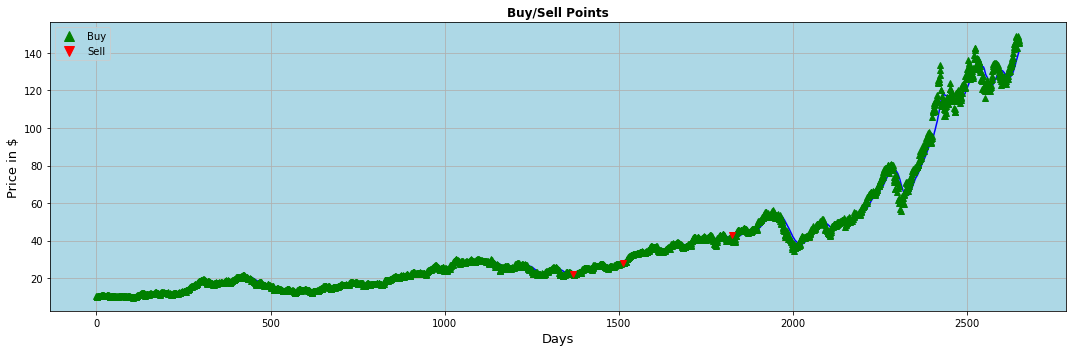

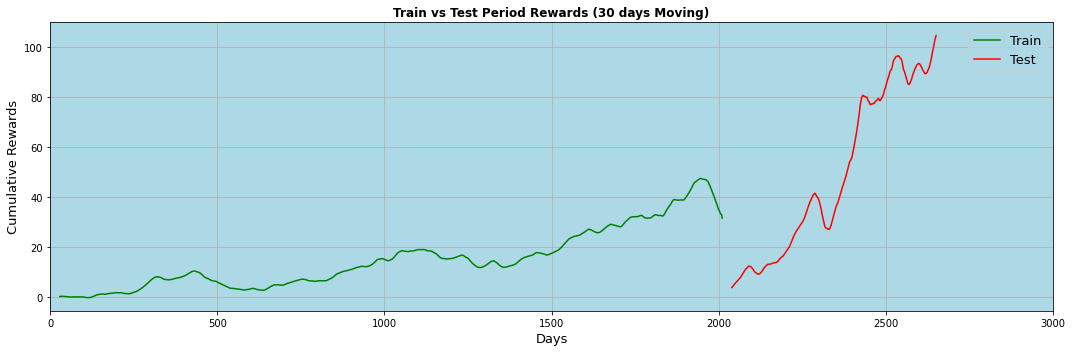

In [42]:
summary(envF, env)

In [43]:
pd.DataFrame(env.return_df)

,price_t,reward_t,action_t,price_t+1
0,36.5119,0.7473,1,37.2592
1,37.2592,0.4552,1,37.7144
2,37.7144,0.2239,1,37.9383
3,37.9383,0.2337,1,38.1720
4,38.1720,-0.8568,1,37.3152
...,...,...,...,...
636,148.5600,0.4300,1,148.9900
637,148.9900,-2.2200,1,146.7700
638,146.7700,-1.7900,1,144.9800
639,144.9800,0.6600,1,145.6400
